# Photon Classification

Photons in this analysis are identified using photon ID variables. However, other particles can also pass this ID. For example, a boosted jet can decay into two photons in such a way that they overlap within the resolution of the detector, mimicking a single photon signature and causing the jet to be misidentified as a ("fake") photon.

We want to classify all particles passing the photon ID as either _real_ or _fake_:
- Real photons ($y=0$)
- Fake photons ($y=1$)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats
import sklearn
import sklearn.linear_model
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from keras import Sequential
from keras.layers import Dense

## ROOT Data Format

The data has been initially processed using the [CERN ROOT data analysis frame work](https://root.cern.ch) and is stored in trees using its TTree() data structure. Observe the following tree->branch->leaf format.

<img src="images/root_tree_browser.png" style="width:400px;height:400px;">
<caption><center> <u>Figure 1 </u>: ROOT TTree structure <br> </center></caption>

This will be converted into a pandas DataFrame using [root_pandas](https://github.com/scikit-hep/root_pandas).

In [2]:
import uproot
file = uproot.open("out_GGJets_M-200To500_Pt-50_13TeV-sherpa_RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1_numEvent5000_1.root")
#ROOT files, directories, and trees are like Python dicts with keys() and values()
file.keys()

['diphoton;1',
 'diphoton/fTree;29',
 'diphoton/fTree;28',
 'diphoton/fTreeFake;11',
 'diphoton/fTreeFake;10']

In [3]:
fTree = file['diphoton/fTree']
fTreeFake = file['diphoton/fTreeFake']




In [4]:
fTreeFake

<TTree 'fTreeFake' (19 branches) at 0x7fb0a0ccaa00>

In [5]:
fTreeFake.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Event                | struct {int64_t run; ... | AsDtype("[('run', '>i8'), (...
TriggerBit           | struct {int32_t HLT_A... | AsDtype("[('HLT_AK4PFDJet60...
TriggerPrescale      | struct {int32_t HLT_A... | AsDtype("[('HLT_AK4PFDJet60...
Jet                  | struct {float jetHT; ... | AsDtype("[('jetHT', '>f4'),...
Photon               | struct {double pt; do... | AsDtype("[('pt', '>f8'), ('...
PhotonGenMatch       | struct {double pt; do... | AsDtype("[('pt', '>f8'), ('...
PhotonGenParent      | struct {double pt; do... | AsDtype("[('pt', '>f8'), ('...
GenMatchPt           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
GenMatchEta          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
GenMatchPhi          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
GenMatchPdgId        | std::

## Simulated Data

The dataset has been constructed using Monte Carlo simulation. The particle collisions and interactions have been generated using [PYTHIA 8](http://home.thep.lu.se/~torbjorn/Pythia.html) and simulated through the [CMS detector](https://cms.cern) using [Geant4](https://geant4.web.cern.ch). This simulation allows us to label all particles passing the photon ID as either real or fake. Note, for actual detector data we do not have this luxury.

In [6]:
df = fTreeFake.arrays(filter_name=['Photon','Event','PhotonGenMatch'], library = 'pd')

In [7]:
df

Event                                                              \
         run    LS    evnum processid bx orbit ptHat  alphaqcd  alphaqed   
0          1   121   120002         0 -1    -1   0.0  0.153054  0.007764   
1          1   121   120010         0 -1    -1   0.0  0.135724  0.007764   
2          1   121   120009         0 -1    -1   0.0  0.104595  0.007764   
3          1   121   120009         0 -1    -1   0.0  0.104595  0.007764   
4          1   121   120003         0 -1    -1   0.0  0.136504  0.007764   
...      ...   ...      ...       ... ..   ...   ...       ...       ...   
555255     1  1370  1369993         0 -1    -1   0.0  0.126107  0.007764   
555256     1  1370  1369999         0 -1    -1   0.0  0.126895  0.007764   
555257     1  1370  1369989         0 -1    -1   0.0  0.111424  0.007764   
555258     1  1370  1370000         0 -1    -1   0.0  0.137363  0.007764   
555259     1  1370  1370000         0 -1    -1   0.0  0.137363  0.007764   

                    ... PhotonGenMatch                          \
            qscale  ...   ptDiff_match matchCategory matchType   
0       311.850891  ...       0.036081             1         8   
1       222.393845  ...       0.031270             1         8   
2       219.131256  ...       0.019475             1         8   
3       219.131256  ...       0.018719             1         8   
4       207.125778  ...       0.005878             1         8   
...            ...  ...            ...           ...       ...   
555255  557.704285  ...       0.010144             1         8   
555256  433.067841  ...       0.016530             1         8   
555257  581.910706  ...       0.017775             1         8   
555258  128.794662  ...       0.008288             1         8   
555259  128.794662  ...       0.026105             1         8   

                                                                           \
       nPhotonMotherDaughters status motherStatus grandmotherStatus pdgId   
0                     -999999      1           11                 3    22   
1                     -999999      1           11                 3    22   
2                     -999999      1           11                 3    22   
3                     -999999      1           11                 3    22   
4                     -999999      1           11                 3    22   
...                       ...    ...          ...               ...   ...   
555255                -999999      1           11                 3    22   
555256                -999999      1           11                 3    22   
555257                -999999      1           11                 3    22   
555258                -999999      1           11                 3    22   
555259                -999999      1           11                 3    22   

                                     
       motherPdgId grandmotherPdgId  
0               22               22  
1               22               22  
2               22               22  
3               22               22  
4               22               22  
...            ...              ...  
555255          22               22  
555256          22               22  
555257          22               22  
555258          22               22  
555259          22               22  

[555260 rows x 124 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555260 entries, 0 to 555259
Columns: 124 entries, ('Event', 'run') to ('PhotonGenMatch', 'grandmotherPdgId')
dtypes: bool(26), float32(38), float64(40), int32(14), int64(6)
memory usage: 318.8 MB


In [9]:
df['Event'].info(), df['Photon'].info(), df['PhotonGenMatch'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555260 entries, 0 to 555259
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   run                      555260 non-null  int64  
 1   LS                       555260 non-null  int64  
 2   evnum                    555260 non-null  int64  
 3   processid                555260 non-null  int64  
 4   bx                       555260 non-null  int64  
 5   orbit                    555260 non-null  int64  
 6   ptHat                    555260 non-null  float32
 7   alphaqcd                 555260 non-null  float32
 8   alphaqed                 555260 non-null  float32
 9   qscale                   555260 non-null  float32
 10  x1                       555260 non-null  float32
 11  x2                       555260 non-null  float32
 12  pdf1                     555260 non-null  float32
 13  pdf2                     555260 non-null  float32
 14  weig

(None, None, None)

- By construction, there are no NULL values. Let's sanity check this.
- Initially, there are $m = 443,783$ examples. Some preprocessing is in order though.

In [10]:
#df.describe(include='all')

In [11]:
df.isnull().sum().sum()

0

In [12]:
len(df)

555260

In [13]:
df.columns

MultiIndex([(         'Event',                    'run'),
            (         'Event',                     'LS'),
            (         'Event',                  'evnum'),
            (         'Event',              'processid'),
            (         'Event',                     'bx'),
            (         'Event',                  'orbit'),
            (         'Event',                  'ptHat'),
            (         'Event',               'alphaqcd'),
            (         'Event',               'alphaqed'),
            (         'Event',                 'qscale'),
            ...
            ('PhotonGenMatch',           'ptDiff_match'),
            ('PhotonGenMatch',          'matchCategory'),
            ('PhotonGenMatch',              'matchType'),
            ('PhotonGenMatch', 'nPhotonMotherDaughters'),
            ('PhotonGenMatch',                 'status'),
            ('PhotonGenMatch',           'motherStatus'),
            ('PhotonGenMatch',      'grandmotherStatus')

In [14]:
df[('Photon','pt')]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555260 entries, 0 to 555259
Columns: 124 entries, ('Event', 'run') to ('PhotonGenMatch', 'grandmotherPdgId')
dtypes: bool(26), float32(38), float64(40), int32(14), int64(6)
memory usage: 318.8 MB


In [15]:
df[0:1]

Event                                                                        \
    run   LS   evnum processid bx orbit ptHat  alphaqcd  alphaqed      qscale   
0     1  121  120002         0 -1    -1   0.0  0.153054  0.007764  311.850891   

   ... PhotonGenMatch                                                        \
   ...   ptDiff_match matchCategory matchType nPhotonMotherDaughters status   
0  ...       0.036081             1         8                -999999      1   

                                                                     
  motherStatus grandmotherStatus pdgId motherPdgId grandmotherPdgId  
0           11                 3    22          22               22  

[1 rows x 124 columns]

In [16]:
df[('PhotonGenMatch', 'pt')]

0         172.447357
1          73.977516
2          69.240997
3          71.424210
4          98.379814
             ...    
555255     57.297596
555256    271.848785
555257    100.965134
555258    193.225464
555259     66.899918
Name: (PhotonGenMatch, pt), Length: 555260, dtype: float64

In [17]:
df['PhotonGenMatch']['pt']

0         172.447357
1          73.977516
2          69.240997
3          71.424210
4          98.379814
             ...    
555255     57.297596
555256    271.848785
555257    100.965134
555258    193.225464
555259     66.899918
Name: pt, Length: 555260, dtype: float64

In [18]:
df[('Photon','passHighPtID')]

0         True
1         True
2         True
3         True
4         True
          ... 
555255    True
555256    True
555257    True
555258    True
555259    True
Name: (Photon, passHighPtID), Length: 555260, dtype: bool

In [19]:
df_new = df.unstack()
df_new.loc['Event','run']

0         1
1         1
2         1
3         1
4         1
         ..
555255    1
555256    1
555257    1
555258    1
555259    1
Length: 555260, dtype: object

In [20]:
df_photon = fTreeFake.arrays(filter_name='Photon', library = 'pd')
df_photongenmatch = fTreeFake.arrays(filter_name='PhotonGenMatch', library = 'pd')
df_event = fTreeFake.arrays(filter_name='Event', library = 'pd')
# df_photon = df_photon['Photon']
# df_photongenmatch = df_photongenmatch['PhotonGenMatch']
# df_event = df_event['Event']

In [21]:
df_photon.head()


Photon                                                     \
           pt       eta       phi     scEta     scPhi        rho   
0  178.902404  1.837603 -0.837241  1.839479 -0.836903  17.625380   
1   76.365470  1.876508 -0.386545  1.885256 -0.386120  20.837276   
2   67.918273  1.871722  2.711424  1.867802  2.711012  27.442591   
3   70.111787 -0.134662 -0.351727 -0.143998 -0.351420  27.442591   
4   97.804881  0.834372  0.536368  0.834158  0.536585  23.845514   

                                                                     ...  \
  chargedHadIso03 neutralHadIso03 photonIso03 rhoCorChargedHadIso03  ...   
0        0.000000        0.307591    0.229857              0.000000  ...   
1        0.000000        0.217988    0.356798              0.000000  ...   
2        0.586927        0.000000    0.929867              0.296035  ...   
3        0.000000        0.000000    1.301904              0.000000  ...   
4        3.804337        0.000000    3.419703              3.537268  ...   

                                                                          \
  passCorPhoIso passSieie passHighPtID passChIsoDenom passCorPhoIsoDenom   
0          True      True         True           True               True   
1          True      True         True           True               True   
2          True      True         True           True               True   
3          True      True         True           True               True   
4          True      True         True           True               True   

                                                                            
  isFakeable isNumeratorObjCand isDenominatorObj isSaturated isMCTruthFake  
0      False               True            False       False         False  
1      False               True            False       False         False  
2      False               True            False       False         False  
3      False               True            False       False         False  
4      False               True            False       False         False  

[5 rows x 80 columns]

In [22]:
df_photongenmatch.head()

PhotonGenMatch                                                   \
              pt       eta       phi deltaR_match deltaR_matchDau   
0     172.447357  1.835380 -0.838219     0.002429      -999999.99   
1      73.977516  1.877721 -0.386379     0.001224      -999999.99   
2      69.240997  1.853928  2.711038     0.017798      -999999.99   
3      71.424210 -0.172132 -0.350323     0.037497      -999999.99   
4      98.379814  0.834212  0.536123     0.000293      -999999.99   

                                                                      \
  ptDiff_match matchCategory matchType nPhotonMotherDaughters status   
0     0.036081             1         8                -999999      1   
1     0.031270             1         8                -999999      1   
2     0.019475             1         8                -999999      1   
3     0.018719             1         8                -999999      1   
4     0.005878             1         8                -999999      1   

                                                                     
  motherStatus grandmotherStatus pdgId motherPdgId grandmotherPdgId  
0           11                 3    22          22               22  
1           11                 3    22          22               22  
2           11                 3    22          22               22  
3           11                 3    22          22               22  
4           11                 3    22          22               22

In [23]:
df_event.head()

Event                                                                        \
    run   LS   evnum processid bx orbit ptHat  alphaqcd  alphaqed      qscale   
0     1  121  120002         0 -1    -1   0.0  0.153054  0.007764  311.850891   
1     1  121  120010         0 -1    -1   0.0  0.135724  0.007764  222.393845   
2     1  121  120009         0 -1    -1   0.0  0.104595  0.007764  219.131256   
3     1  121  120009         0 -1    -1   0.0  0.104595  0.007764  219.131256   
4     1  121  120003         0 -1    -1   0.0  0.136504  0.007764  207.125778   

   ...                                                                       \
   ... weightLumi weightAll interactingParton1PdgId interactingParton2PdgId   
0  ...   0.004813  0.000963                  -99999                  -99999   
1  ...   0.004813  0.000481                  -99999                  -99999   
2  ...   0.004813  0.004813                  -99999                  -99999   
3  ...   0.004813  0.004813                  -99999                  -99999   
4  ...   0.004813  0.000481                  -99999                  -99999   

                                                                                
  pdf_id1 pdf_id2 npv_true beamHaloIDLoose beamHaloIDTight beamHaloIDTight2015  
0       2      21   -99999           False           False               False  
1       1       3   -99999            True           False               False  
2       2      -2   -99999           False           False               False  
3       2      -2   -99999           False           False               False  
4      -2       4   -99999           False           False               False  

[5 rows x 29 columns]

## Data Preprocessing

We apply the following pre-selection on all examples:
- Pass photon ID
- Located inside the EB or EE detectors (these are the CMS ECAL barrel and endcap detectors, respectively)
- Are high energy, above 50 GeV
- Have small shower shapes along the $\phi$-direction (this eliminates a certain type of fakes produced from another physical source) 

Now, $m = 156,202$

######-------------------------------------------------------------------------

In [24]:
df = df[df[('Photon','passHighPtID')] == 1]
df = df[(df[('Photon','isEB')]==True) | (df[('Photon','isEE')]==True)]
df = df[(df[('Photon','pt')] > 50.0) & (df[('Photon','sigmaIphiIphi5x5')] > 0.009)]
len(df)

528339

In [25]:
df

Event                                                              \
         run    LS    evnum processid bx orbit ptHat  alphaqcd  alphaqed   
0          1   121   120002         0 -1    -1   0.0  0.153054  0.007764   
1          1   121   120010         0 -1    -1   0.0  0.135724  0.007764   
2          1   121   120009         0 -1    -1   0.0  0.104595  0.007764   
3          1   121   120009         0 -1    -1   0.0  0.104595  0.007764   
4          1   121   120003         0 -1    -1   0.0  0.136504  0.007764   
...      ...   ...      ...       ... ..   ...   ...       ...       ...   
555255     1  1370  1369993         0 -1    -1   0.0  0.126107  0.007764   
555256     1  1370  1369999         0 -1    -1   0.0  0.126895  0.007764   
555257     1  1370  1369989         0 -1    -1   0.0  0.111424  0.007764   
555258     1  1370  1370000         0 -1    -1   0.0  0.137363  0.007764   
555259     1  1370  1370000         0 -1    -1   0.0  0.137363  0.007764   

                    ... PhotonGenMatch                          \
            qscale  ...   ptDiff_match matchCategory matchType   
0       311.850891  ...       0.036081             1         8   
1       222.393845  ...       0.031270             1         8   
2       219.131256  ...       0.019475             1         8   
3       219.131256  ...       0.018719             1         8   
4       207.125778  ...       0.005878             1         8   
...            ...  ...            ...           ...       ...   
555255  557.704285  ...       0.010144             1         8   
555256  433.067841  ...       0.016530             1         8   
555257  581.910706  ...       0.017775             1         8   
555258  128.794662  ...       0.008288             1         8   
555259  128.794662  ...       0.026105             1         8   

                                                                           \
       nPhotonMotherDaughters status motherStatus grandmotherStatus pdgId   
0                     -999999      1           11                 3    22   
1                     -999999      1           11                 3    22   
2                     -999999      1           11                 3    22   
3                     -999999      1           11                 3    22   
4                     -999999      1           11                 3    22   
...                       ...    ...          ...               ...   ...   
555255                -999999      1           11                 3    22   
555256                -999999      1           11                 3    22   
555257                -999999      1           11                 3    22   
555258                -999999      1           11                 3    22   
555259                -999999      1           11                 3    22   

                                     
       motherPdgId grandmotherPdgId  
0               22               22  
1               22               22  
2               22               22  
3               22               22  
4               22               22  
...            ...              ...  
555255          22               22  
555256          22               22  
555257          22               22  
555258          22               22  
555259          22               22  

[528339 rows x 124 columns]

## Data Visualization

- Photon $p_T$ shows most photons fall towards the lower side of the energy spectrum
- Photon $\eta$ vs. $\phi$ shows where the photons are located inside the ECAL (with the EB and EE separated by a gap on both sides)
- Photon $\sigma_{i\eta i\eta}$ shows the width of the photon shower along the $\eta$-direction (with different distributions in the EB and EE regions)
- Photon Iso$_{Ch}$ shows that most photons have little activity around them and are well isolated

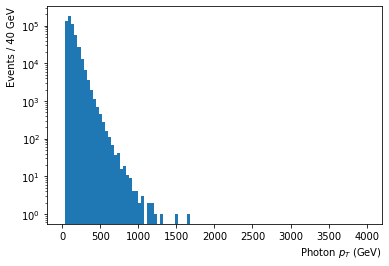

In [26]:
n_bins_pt = 100;
#(max(df['Photon_pt'])-min(df['Photon_pt']))/60
#bins=np.arange(min(data), max(data) + binwidth, binwidth)
df[('Photon','pt')].plot.hist(bins=n_bins_pt,range=(0,4000),log=True); #weights=df['Event_weightAll']
plt.xlabel('Photon $p_T$ (GeV)', horizontalalignment='right', x=1.0);
plt.ylabel('Events / '+str(int(4000/n_bins_pt))+' GeV', horizontalalignment='right', y=1.0);

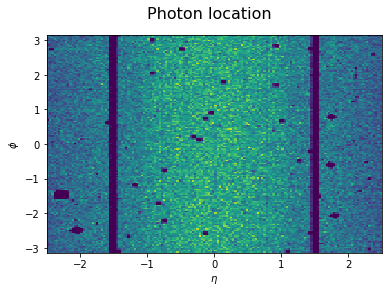

In [27]:
#df.plot.scatter('Photon_scEta', 'Photon_scPhi');
plt.hist2d(df[('Photon','scEta')],df[('Photon','scPhi')],bins=150); #weights=df['Event_weightAll']
plt.suptitle('Photon location',fontsize=16)
plt.xlabel('$\eta$');
plt.ylabel('$\phi$');

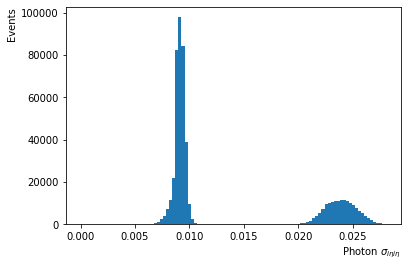

In [28]:
df[('Photon','sigmaIetaIeta5x5')].plot.hist(bins=100,log=False); #weights=df['Event_weightAll']
plt.xlabel('Photon $\sigma_{i\eta i\eta}$', horizontalalignment='right', x=1.0);
plt.ylabel('Events', horizontalalignment='right', y=1.0);

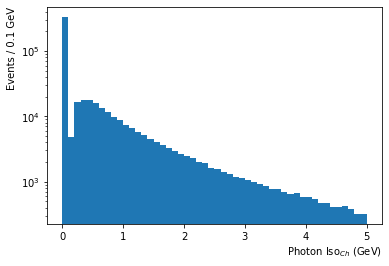

In [29]:
df[('Photon','chargedHadIso03')].plot.hist(bins=50,log=True); #weights=df['Event_weightAll']
plt.xlabel('Photon Iso$_{Ch}$ (GeV)', horizontalalignment='right', x=1.0);
plt.ylabel('Events / '+str(5/50)+' GeV', horizontalalignment='right', y=1.0);

## Create labels

Let's encode the fake criteria into a single label:
- Real photons ($y=0$)
- Fake photons ($y=1$)

Store this as a NumPy array `Y_train`.

In [30]:
def is_fake(row):
    if (row[('Photon','passHighPtID')] == 1) and ((row[('PhotonGenMatch','matchCategory')] == 1) or (row[('PhotonGenMatch','matchCategory')] == 2)) and (row[('PhotonGenMatch','matchType')] == 1):
        val = 1
    else:
        val = 0
    return val    

In [31]:
df[2:3][('Photon','passHighPtID')], df[2:3][('PhotonGenMatch','matchCategory')], df[2:3][('PhotonGenMatch','matchCategory')], df[2:3][('PhotonGenMatch','matchType')]

(2    True
 Name: (Photon, passHighPtID), dtype: bool,
 2    1
 Name: (PhotonGenMatch, matchCategory), dtype: int32,
 2    1
 Name: (PhotonGenMatch, matchCategory), dtype: int32,
 2    8
 Name: (PhotonGenMatch, matchType), dtype: int32)

In [32]:
df['fake'] = df.apply(is_fake, axis=1)

In [33]:
df.head()

Event                                                                        \
    run   LS   evnum processid bx orbit ptHat  alphaqcd  alphaqed      qscale   
0     1  121  120002         0 -1    -1   0.0  0.153054  0.007764  311.850891   
1     1  121  120010         0 -1    -1   0.0  0.135724  0.007764  222.393845   
2     1  121  120009         0 -1    -1   0.0  0.104595  0.007764  219.131256   
3     1  121  120009         0 -1    -1   0.0  0.104595  0.007764  219.131256   
4     1  121  120003         0 -1    -1   0.0  0.136504  0.007764  207.125778   

   ... PhotonGenMatch                                                       \
   ...  matchCategory matchType nPhotonMotherDaughters status motherStatus   
0  ...              1         8                -999999      1           11   
1  ...              1         8                -999999      1           11   
2  ...              1         8                -999999      1           11   
3  ...              1         8                -999999      1           11   
4  ...              1         8                -999999      1           11   

                                                       fake  
  grandmotherStatus pdgId motherPdgId grandmotherPdgId       
0                 3    22          22               22    0  
1                 3    22          22               22    0  
2                 3    22          22               22    0  
3                 3    22          22               22    0  
4                 3    22          22               22    0  

[5 rows x 125 columns]

In [34]:
#df[['PhotonGenMatch_matchCategory','PhotonGenMatch_matchType','fake']][df['fake']==1]
df['fake'].value_counts()

0    527985
1       354
Name: fake, dtype: int64

In [35]:
df['fake'].isnull()

0         False
1         False
2         False
3         False
4         False
          ...  
555255    False
555256    False
555257    False
555258    False
555259    False
Name: fake, Length: 528339, dtype: bool

In [36]:
df['fake'].isnull().sum()

0

In [37]:
Y = df['fake'].to_numpy()
Y.shape

#Y_train = Y.reshape(Y.shape[0],1)
#Y_train.shape

(528339,)

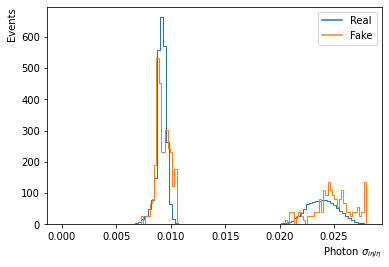

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
df[('Photon','sigmaIetaIeta5x5')][df['fake']==0].plot.hist(bins=100,density=True,log=False,label='Real',histtype='step'); # weights=df['Event_weightAll'][df['fake']==0]
df[('Photon','sigmaIetaIeta5x5')][df['fake']==1].plot.hist(bins=100,density=True,log=False,label='Fake',histtype='step'); # weights=df['Event_weightAll'][df['fake']==1]
plt.xlabel('Photon $\sigma_{i\eta i\eta}$', horizontalalignment='right', x=1.0);
plt.ylabel('Events', horizontalalignment='right', y=1.0);
plt.legend(loc='upper right');
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)
plt.show()

In [39]:
df[('Photon','isEE')]

0          True
1          True
2          True
3         False
4         False
          ...  
555255    False
555256     True
555257     True
555258    False
555259    False
Name: (Photon, isEE), Length: 528339, dtype: bool

In [83]:
df[('Photon','isEE')].value_counts()

False    1243
True      166
Name: (Photon, isEE), dtype: int64

## Prepare features

Organize desired features into NumPy array `X_train`. Normalize features by mean and standardize by the standard deviation.


In [42]:
features = [('Photon','pt'),('Photon','eta'),('Photon','phi'),('Photon','iEta'),('Photon','iPhi'),('Photon','rho'),('Photon','chargedHadIso03'),('Photon','neutralHadIso03'),('Photon','photonIso03'),('Photon','hadTowerOverEm'),('Photon','r9_5x5'),('Photon','sigmaIetaIeta5x5'),('Photon','sigmaIphiIphi5x5'),('Photon','sigmaIetaIphi5x5'),('Photon','maxEnergyXtal')]
X = df[features].to_numpy()

In [43]:
X.shape

(528339, 15)

In [44]:
scaler = preprocessing.StandardScaler().fit(X)

In [45]:
X_scaled = scaler.transform(X)

In [46]:
X_scaled.shape

(528339, 15)

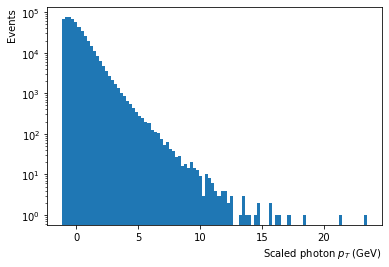

In [47]:
plt.hist(x=X_scaled[:,0], bins=100,log=True);
plt.xlabel('Scaled photon $p_T$ (GeV)', horizontalalignment='right', x=1.0);
plt.ylabel('Events', horizontalalignment='right', y=1.0);

## Feature Correlation

- The strongest correlations are among the angular coordinates, shower shapes along the angular coordinates, and among the different energy variables

In [48]:
corr = df[features].corr()

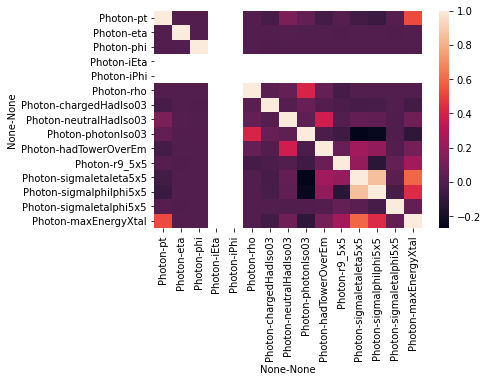

In [49]:
sns.heatmap(corr);

## Split dataset

Let's divided the dataset into training and testing datasets.

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2)

In [51]:
print ("Number of total examples: " + str(X.shape[0]))
print ("Number of training examples: " + str(X_train.shape[0]))
print ("Number of testing examples: " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Number of total examples: 528339
Number of training examples: 422671
Number of testing examples: 105668
X_train shape: (422671, 15)
Y_train shape: (422671,)
X_test shape: (105668, 15)
Y_test shape: (105668,)


In [190]:
# # Just using NN only
# from tensorflow import keras
# model = keras.Sequential([
#      keras.layers.Dense(10, input_dim=len(features)), 
#      keras.layers.Dense(10, activation='relu'), # first hidden layer
#      keras.layers.Dense(10, activation='relu'), # second hidden layer
#      keras.layers.Dense(1, activation='sigmoid') # output layer
# ])
# model.compile(
#     optimizer='SGD', # using SGM
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )
# model.fit(X_train, Y_train, epochs=10)

Epoch 1/10
13209/13209 [==============================] - 8s 590us/step - loss: 0.0139 - accuracy: 0.9979
Epoch 2/10
13209/13209 [==============================] - 7s 561us/step - loss: 0.0051 - accuracy: 0.9993
Epoch 3/10
13209/13209 [==============================] - 7s 561us/step - loss: 0.0048 - accuracy: 0.9993
Epoch 4/10
13209/13209 [==============================] - 7s 563us/step - loss: 0.0047 - accuracy: 0.9993
Epoch 5/10
13209/13209 [==============================] - 7s 561us/step - loss: 0.0046 - accuracy: 0.9993
Epoch 6/10
13209/13209 [==============================] - 7s 558us/step - loss: 0.0045 - accuracy: 0.9993
Epoch 7/10
13209/13209 [==============================] - 7s 555us/step - loss: 0.0044 - accuracy: 0.9993
Epoch 8/10
13209/13209 [==============================] - 8s 600us/step - loss: 0.0044 - accuracy: 0.9993
Epoch 9/10
13209/13209 [==============================] - 7s 557us/step - loss: 0.0043 - accuracy: 0.9993
Epoch 10/10
13209/13209 [=====================

In [191]:
# model.evaluate(X_test, Y_test)

3303/3303 [==============================] - 2s 471us/step - loss: 0.0045 - accuracy: 0.9993


[0.0044538420625030994, 0.9993375539779663]

In [192]:
# from sklearn.metrics import confusion_matrix, classification_report
# y_pred = model.predict(X_test)
# y_pred_classes=[np.argmax(i) for i in y_pred]
# print("Classification Report: \n" , classification_report(Y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    105598
           1       0.00      0.00      0.00        70

    accuracy                           1.00    105668
   macro avg       0.50      0.50      0.50    105668
weighted avg       1.00      1.00      1.00    105668



/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Simple Logistic Regression Classifier

We train a simple linear classifier using logistic regression to get a baseline for performance on this dataset.

In [52]:
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X_train, Y_train);

In [53]:
LR_predictions_train = clf.predict(X_train)
print ('Accuracy of logistic regression: %d' % float((np.dot(Y_train,LR_predictions_train) + np.dot(1-Y_train,1-LR_predictions_train))/float(Y_train.size)*100) +'% ' + "(training set)")

Accuracy of logistic regression: 99% (training set)


In [54]:
LR_predictions_test = clf.predict(X_test)
print ('Accuracy of logistic regression: %d' % float((np.dot(Y_test,LR_predictions_test) + np.dot(1-Y_test,1-LR_predictions_test))/float(Y_test.size)*100) +'% ' + "(test set)")

Accuracy of logistic regression: 99% (test set)


- The accuracy is promising; however, the classes are skewed so let's check the F1 score.

In [55]:
sklearn.metrics.f1_score(Y_test, LR_predictions_test)

0.0

In [56]:
np.dot(Y_test,LR_predictions_test)/sum(Y_test==1)*100.

0.0

In [57]:
np.dot(1-Y_test,1-LR_predictions_test)/sum(Y_test==0)*100.

100.0

## Nonlinear classifier

We use a 4-layer deep neural network as our classifier, comprising 3 hidden layers. L2 regularization is used.

In [58]:
clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(10,10,4), max_iter=1500, learning_rate_init=0.0001, random_state=1)
clf_NN.fit(X_train,Y_train)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(10, 10, 4),
              learning_rate_init=0.0001, max_iter=1500, random_state=1,
              solver='lbfgs')

In [59]:
NN_predictions_train = clf_NN.predict(X_train)
print ('Accuracy of NN: %d' % float((np.dot(Y_train,NN_predictions_train) + np.dot(1-Y_train,1-NN_predictions_train))/float(Y_train.size)*100) +'% ' + "(training set)")

Accuracy of NN: 99% (training set)


In [60]:
NN_predictions_test = clf_NN.predict(X_test)
print ('Accuracy of NN: %d' % float((np.dot(Y_test,NN_predictions_test) + np.dot(1-Y_test,1-NN_predictions_test))/float(Y_test.size)*100) +'% ' + "(test set)")

Accuracy of NN: 99% (test set)


In [61]:
sklearn.metrics.f1_score(Y_test, NN_predictions_test)

0.0

In [62]:
np.dot(Y_test,NN_predictions_test)/sum(Y_test==1)*100.

0.0

In [63]:
np.dot(1-Y_test,1-NN_predictions_test)/sum(Y_test==0)*100.

100.0

# DNN with Keras

In [64]:
classifier = Sequential()
classifier.add(Dense(10, activation='relu', kernel_initializer='normal', input_dim=len(features)))
classifier.add(Dense(10, activation='relu', kernel_initializer='normal'))
classifier.add(Dense(4, activation='relu', kernel_initializer='normal'))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [65]:
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
classifier.fit(X_train,Y_train, batch_size=100, epochs=10)

Epoch 1/10
4227/4227 [==============================] - 4s 709us/step - loss: 0.0300 - accuracy: 0.9993
Epoch 2/10
4227/4227 [==============================] - 3s 710us/step - loss: 0.0046 - accuracy: 0.9993
Epoch 3/10
4227/4227 [==============================] - 3s 722us/step - loss: 0.0043 - accuracy: 0.9993
Epoch 4/10
4227/4227 [==============================] - 3s 707us/step - loss: 0.0043 - accuracy: 0.9993
Epoch 5/10
4227/4227 [==============================] - 3s 718us/step - loss: 0.0042 - accuracy: 0.9993
Epoch 6/10
4227/4227 [==============================] - 3s 709us/step - loss: 0.0042 - accuracy: 0.9993
Epoch 7/10
4227/4227 [==============================] - 3s 708us/step - loss: 0.0041 - accuracy: 0.9993
Epoch 8/10
4227/4227 [==============================] - 3s 700us/step - loss: 0.0041 - accuracy: 0.9993
Epoch 9/10
4227/4227 [==============================] - 3s 731us/step - loss: 0.0041 - accuracy: 0.9993
Epoch 10/10
4227/4227 [==============================] - 3s 778u

In [66]:
classifier.evaluate(X_test, Y_test)

3303/3303 [==============================] - 2s 504us/step - loss: 0.0047 - accuracy: 0.9993


[0.004676843527704477, 0.9992523789405823]

In [67]:
Y_pred_keras = classifier.predict(X_test)

In [68]:
Y_pred_keras = (Y_pred_keras > 0.5)

In [69]:
print ('Accuracy of NN: %d' % float((np.dot(Y_test,Y_pred_keras) + np.dot(1-Y_test,1-Y_pred_keras))/float(Y_test.size)*100) +'% ' + "(test set)")

Accuracy of NN: 99% (test set)


In [70]:
sklearn.metrics.f1_score(Y_test, Y_pred_keras)

0.0

In [71]:
np.squeeze(np.dot(Y_test,Y_pred_keras)/sum(Y_test==1))*100.

0.0

In [72]:
np.squeeze(np.dot(1-Y_test,1-Y_pred_keras)/sum(Y_test==0))*100.

100.0

In [74]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = classifier.predict(X_test)
y_pred_classes=[np.argmax(i) for i in y_pred]
print("Classification Report: \n" , classification_report(Y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    105589
           1       0.00      0.00      0.00        79

    accuracy                           1.00    105668
   macro avg       0.50      0.50      0.50    105668
weighted avg       1.00      1.00      1.00    105668



/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test on Production Data

We further check our classifier's performance by checking it on other data. First, we need to preprocess our features. This dataset is heavily skewed between classes.

In [75]:
GGJets = uproot.open("out_QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8_RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15_ext2-v2_numEvent5000_1.root:diphoton/fTreeFake")




In [76]:
df_test = GGJets.arrays(filter_name=['Photon','Event','PhotonGenMatch'], library = 'pd')

In [77]:
df_test.head()

Event                                                                  \
    run  LS   evnum processid bx orbit        ptHat  alphaqcd  alphaqed   
0     1  63  124040       114 -1    -1  3518.259521  0.078520  0.008155   
1     1  63  124049       114 -1    -1  3406.442139  0.078747  0.008152   
2     1  63  124069       114 -1    -1  3319.923096  0.078930  0.008150   
3     1  63  124071       113 -1    -1  3517.509033  0.078521  0.008155   
4     1  63  124159       114 -1    -1  3266.912354  0.079044  0.008148   

                ... PhotonGenMatch                          \
        qscale  ...   ptDiff_match matchCategory matchType   
0  3518.259521  ...       0.116790             1         5   
1  3406.442139  ...       0.992110             1         1   
2  3319.923096  ...       0.022480             1         5   
3  3517.509033  ...       0.031469             1         5   
4  3266.912354  ...       0.012744             1         2   

                                                                      \
  nPhotonMotherDaughters status motherStatus grandmotherStatus pdgId   
0                     10      1           44                23    22   
1                      2      1            2                 2    22   
2                     18      1           23                21    22   
3                     31      1           44                23    22   
4                     14      1            4          -9999999    22   

                                
  motherPdgId grandmotherPdgId  
0           2                2  
1         111              223  
2           2                2  
3           2                2  
4        2212         -9999999  

[5 rows x 124 columns]

In [78]:
df_test = df_test[df_test[('Photon','passHighPtID')] == 1]
df_test = df_test[(df_test[('Photon','isEB')]==True) | (df_test[('Photon','isEE')]==True)]
df_test = df_test[(df_test[('Photon','pt')] > 50.0) & (df_test[('Photon','sigmaIphiIphi5x5')] > 0.009)]
len(df_test)

1409

In [79]:
df_test['fake'] = df_test.apply(is_fake, axis=1)

In [80]:
df_test['fake'].value_counts()

0    1400
1       9
Name: fake, dtype: int64

In [81]:
Y_prod = df_test['fake'].to_numpy()
X_prod = df_test[features].to_numpy()

In [82]:
X_prod_scaled = scaler.transform(X_prod)

In [83]:
NN_predictions_prod = clf_NN.predict(X_prod_scaled)
print ('Accuracy of NN: %d' % float((np.dot(Y_prod,NN_predictions_prod) + np.dot(1-Y_prod,1-NN_predictions_prod))/float(Y_prod.size)*100) +'% ' + "(production test set)")

Accuracy of NN: 99% (production test set)


In [84]:
sklearn.metrics.f1_score(Y_prod, NN_predictions_prod)

0.0

In [85]:
np.dot(Y_prod,NN_predictions_prod)/sum(Y_prod==1)*100.

0.0

In [227]:
np.dot(1-Y_prod,1-NN_predictions_prod)/sum(Y_prod==0)*100.

100.0